___
# Create the Dataset as a single csv file from the 
___

In [1]:
import numpy as np
import pandas as pd
#import tensorflow as tf
from os import listdir
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline

## Functions to read data from files

In [2]:
def filelist_from_directory(directory):
    '''
    Given the directory, return all folder in the directory
    
    Note:
    Insider the directory, the folders are the labels of the data.
    In each folder there are 500 ish photos of that fruit
    There is a training and test data set with equivalent data structure
    
    '''
    # list all folders (note folder names are the labels)
    fruit_folders = [folder for folder in listdir(directory)]
    
    #Loop through each folder and each jpg file. Record the Fruit label, Directory and filename.
    fruits_labels=[]
    for fruit in fruit_folders:
        fruit_folder_string = directory+'/'+fruit
        fruitpictures = listdir(fruit_folder_string)
        for picture in fruitpictures:
            fruits_labels.append([fruit, fruit_folder_string+'/'+picture, picture])
    
    #Return the list to a dataframe
    return pd.DataFrame(fruits_labels, columns=['Fruit','Full filename','File'])

def create_dataset(filelist):
    '''
    From a list of all jpg file, append the pictures as an array
    
    '''
   
    # Takes the list created and bring back an array of 100x100x3 representing the picture
    photos = []
    for photo in filelist['Full filename']: #Column 1 is the directory 
        im = mpimg.imread(photo)
        photos.append(im)

    X = np.array(photos)
    y= filelist['Fruit'].values
    
    return X, y

def get_data(directory, start_number=0, number_of_items=1000000000000000):
    filelist = filelist_from_directory(directory)[start_number: start_number+number_of_items]
    return create_dataset(filelist)
    

In [3]:
training_directory = './data/fruits/fruits-360/Training'
testing_directory = './data/fruits/fruits-360/Test'

## Create smaller sets of data for training models more quickly

In [8]:
from sklearn.model_selection import train_test_split

# Create a random list of files from training directory to be used with model fitting
fileList = filelist_from_directory(training_directory)
fileList.to_csv('Full_index_train.csv' .format(i))
for i in [5000,10000,20000,30000]:
    fileList_small, throw_away = train_test_split(fileList, train_size=i)
    fileList_small.to_csv('limited_training_{}_records.csv' .format(i))

In [10]:
from sklearn.model_selection import train_test_split
# Create a random list of files from training directory to be used with model fitting
fileList = filelist_from_directory(testing_directory)
fileList.to_csv('Full_index_test.csv' .format(i))

for i in [1000,5000,10000]:
    fileList_small, throw_away = train_test_split(fileList, train_size=i)
    fileList_small.to_csv('limited_testing_{}_records.csv' .format(i))

# Create 'redness', 'blueness' and 'greeness' plots

In [5]:
filelist = filelist_from_directory(training_directory)
length = len(filelist)

size=5000
iterations = 2 # int(length/size) +1

total_df = pd.DataFrame([], columns =['label', 'proportion not white', 'redness', \
                                     'greeness', 'blueness'] )

for i in range(0,iterations):
    print(f'getting data {i}')
    X, y = create_dataset(filelist.iloc[size*i:size*(i+1), :])
    df = pd.DataFrame(y.ravel(), columns=['label'])
    
    #Calculate proportion white and avg. colour
    threshold = 240
    below_threshold = X <threshold
    mask = np.any(below_threshold, axis=3)
    mask_size = mask.sum(axis=(1,2))
    df['proportion not white'] = mask_size
    df['redness'] = (X[:,:,:,0]*mask).sum(axis=(1,2))/mask_size
    df['greeness'] = (X[:,:,:,1]*mask).sum(axis=(1,2))/mask_size
    df['blueness'] = (X[:,:,:,2]*mask).sum(axis=(1,2))/mask_size
    total_df = pd.concat([total_df, df], axis=0)
    print(f'completed {i}')

getting data 0
calculating mask
completed 0
getting data 1
calculating mask
completed 1


### Clustering

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage

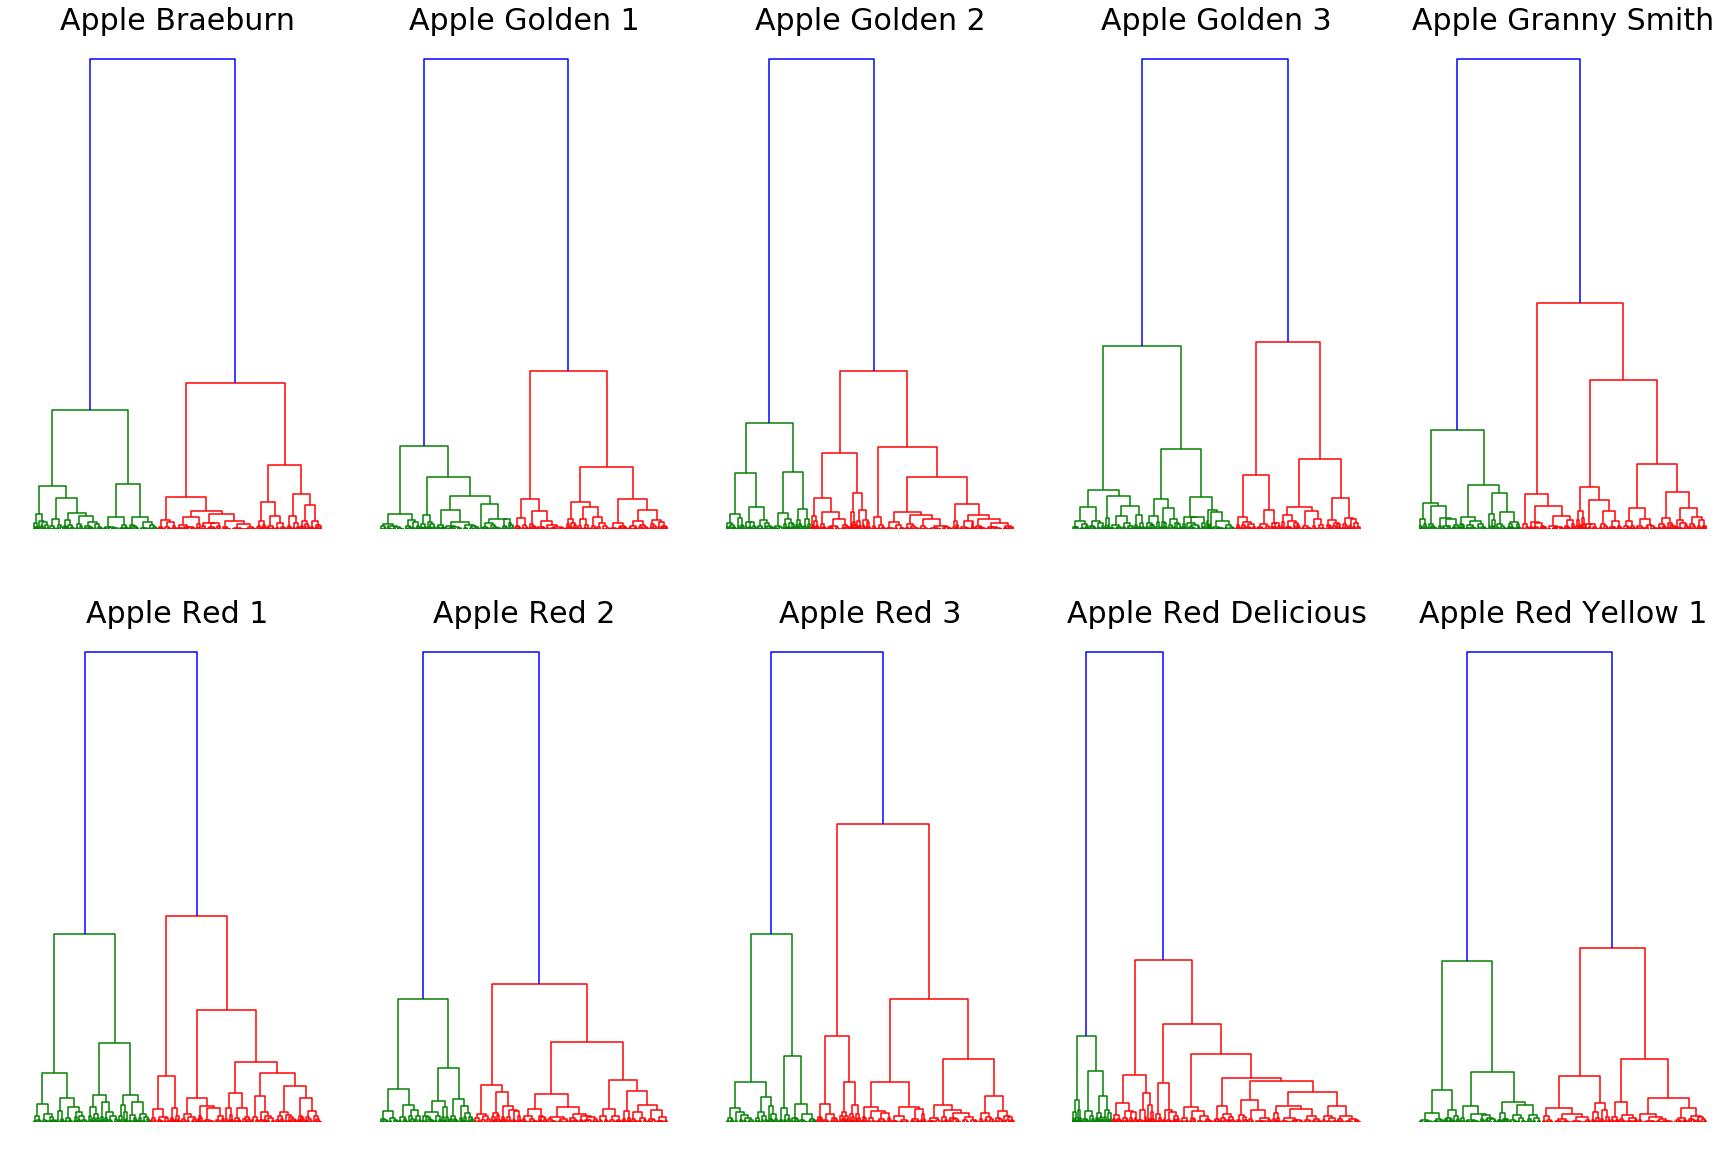

In [11]:
plt.figure(figsize=(30,20))
for iterator, fruit in enumerate(total_df['label'].unique()[:10]):
    plt.subplot(2,5,iterator+1)
    link = linkage(total_df[total_df['label']==fruit].loc[:,['redness','greeness','blueness']], 'ward')
    dendrogram(
    link,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.  # font size for the x axis labels
    )
    plt.title(fruit, size = 30)
    plt.axis('off')

plt.savefig('aglomerative tree.jpg')

### PCA 

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

#Convert labels to numbers
le = LabelEncoder()
le.fit(total_df['label'])
total_df['label_number'] = le.transform(total_df['label'])

#Copute principal components
pca = PCA(n_components=2)
data_principal_components = pca.fit_transform(total_df[['redness', 'greeness', 'blueness']])

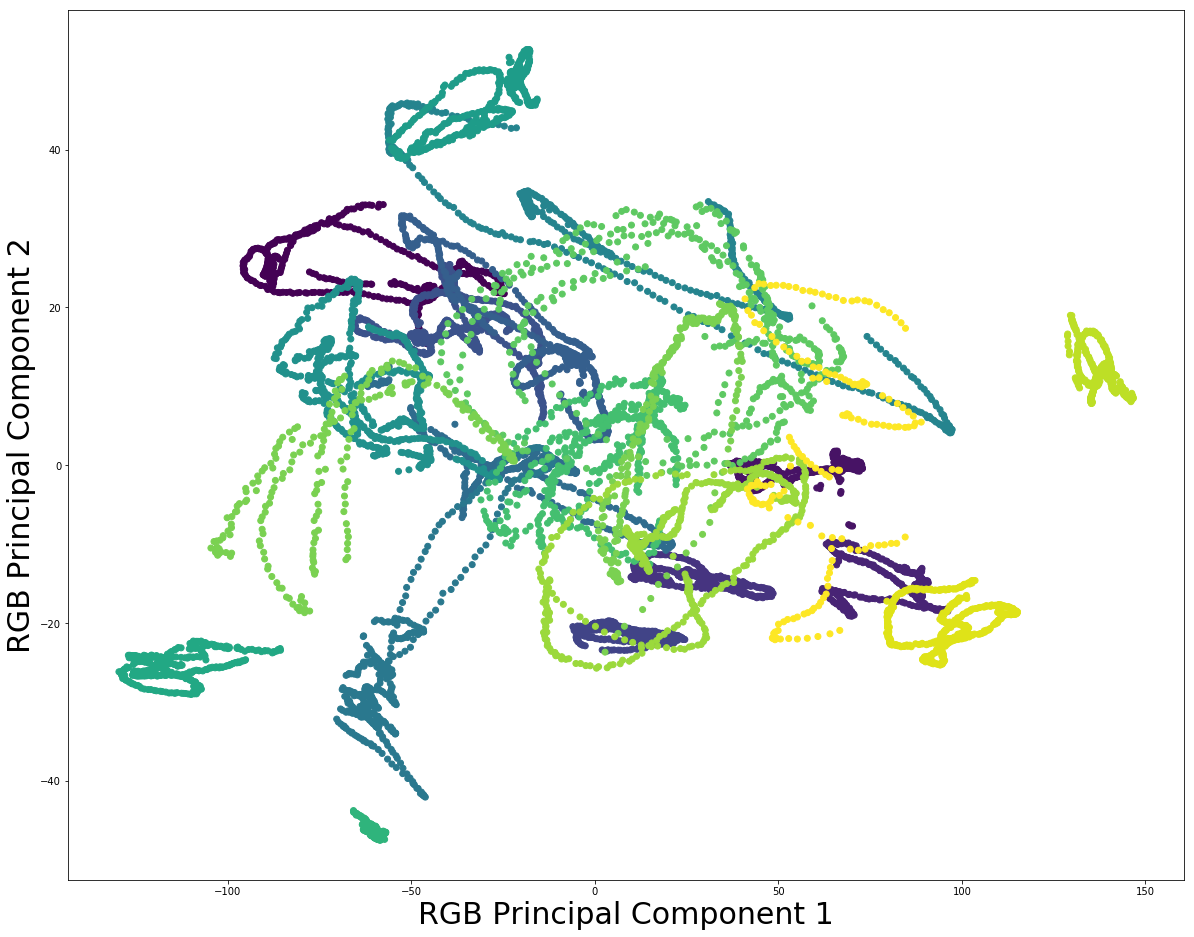

In [16]:
plt.figure(figsize=(20,16))
plt.scatter(data_principal_components[:,0], data_principal_components[:,1], c=total_df['label_number'])
#plt.title('First 10000 images plotted plotted by average colours of image')
plt.xlabel('RGB Principal Component 1', size=30)
plt.ylabel('RGB Principal Component 2', size = 30)
plt.savefig('PC_plot.jpg')

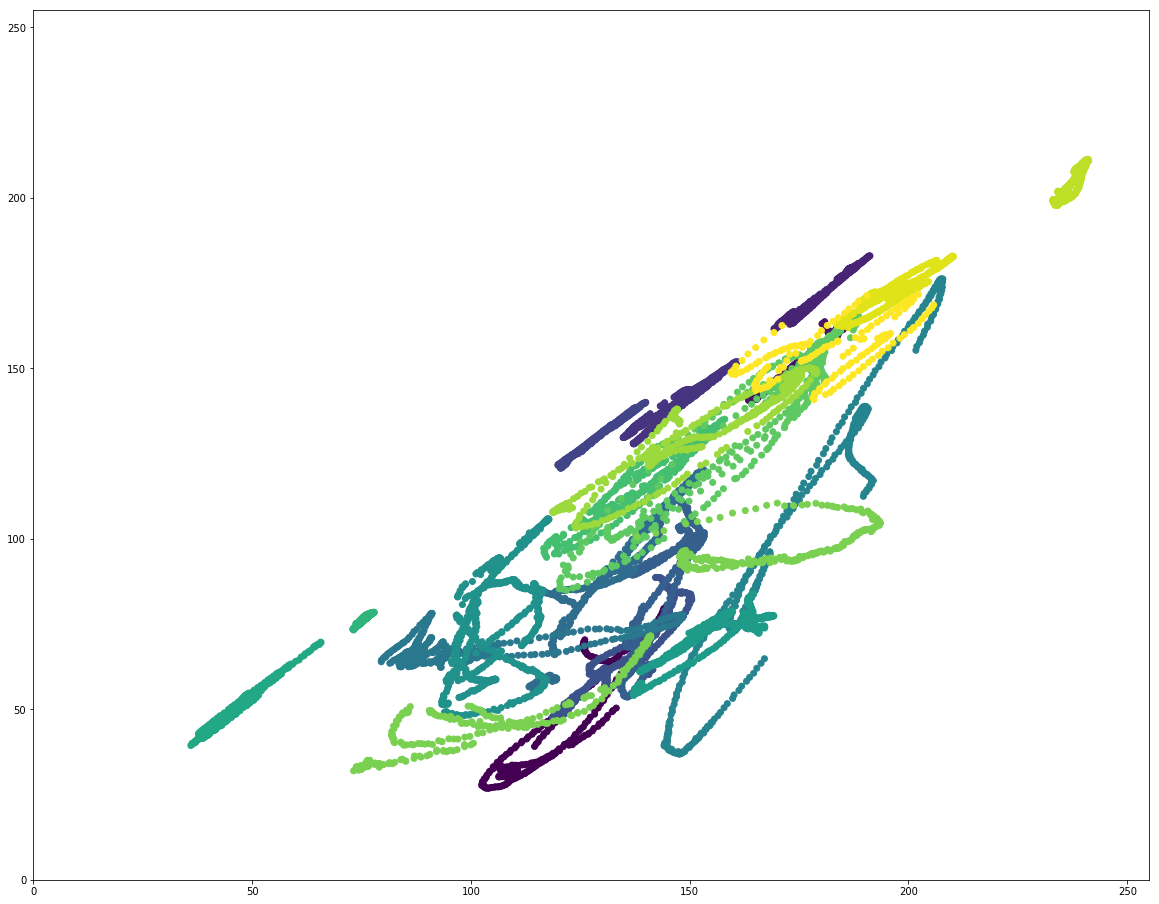

In [9]:
plt.figure(figsize=(20,16))
plt.scatter(total_df['redness'], total_df['greeness'], c=total_df['label_number'])
plt.xlim(0,255);
plt.ylim(0,255);

### Create 3D plot of the data in RGB space (will be used in a GIF)

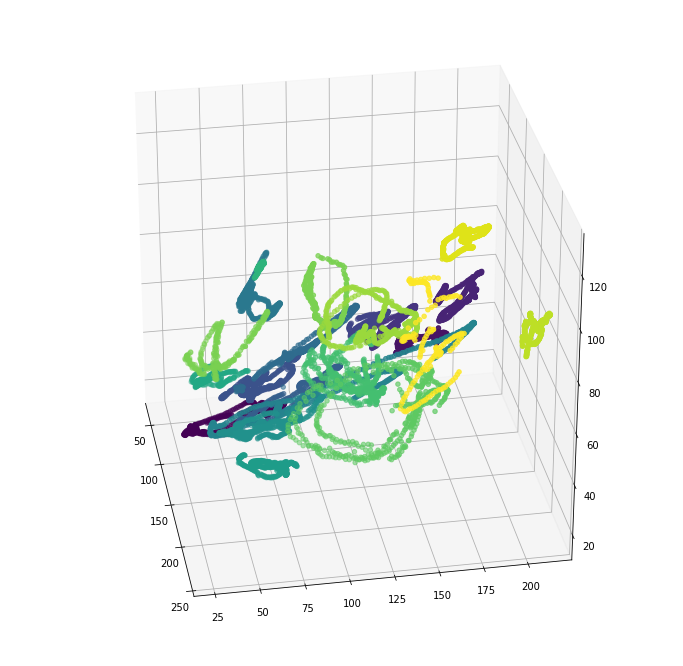

In [6]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12));
ax = fig.add_subplot(111, projection='3d');

ax.scatter(xs=total_df['redness'], ys=total_df['greeness'], zs=total_df['blueness'], \
           zdir='z', s=20, c=total_df['label_number'], depthshade=True);

for angle in range(0, 360, 10):
    ax.view_init(30, angle);
    plt.savefig(f'fruit3D_{angle}.jpg')

In [19]:
filelist = pd.read_csv('./Dataset_index/limited_data_5000_records' )
X,y = create_dataset(filelist)

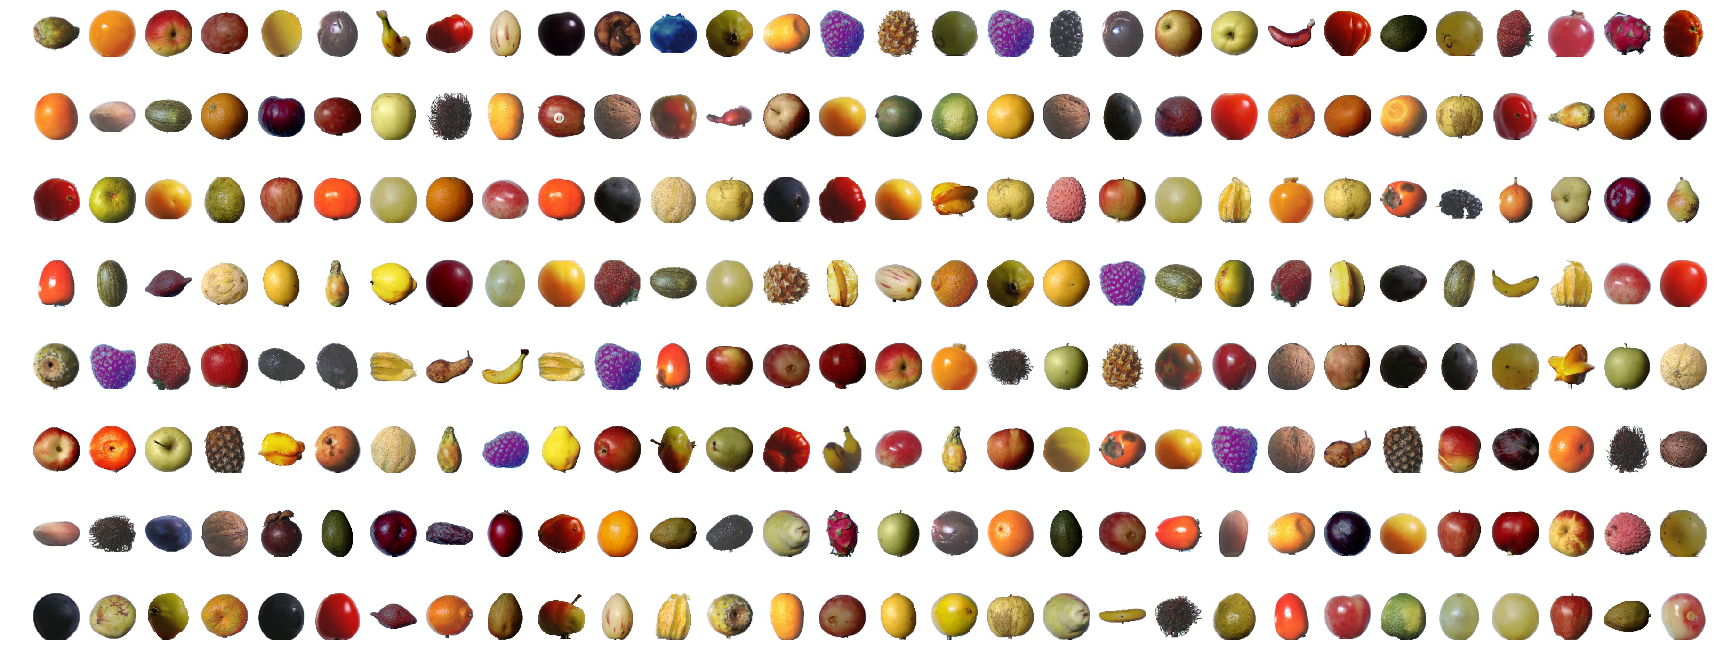

In [27]:

plt.figure(figsize=(30,12))
for i in range(240):
    plt.subplot(8,30,i+1)
    plt.imshow(X[i,:,:,:])
    #plt.title(y[i], size = 10)
    plt.axis('off')

plt.savefig('Fruit2.jpg')
